In [99]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
seed(1)

In [100]:
#operator definitionis
N = 2
si = qeye(2)
sx = 0.5*sigmax()
sy = 0.5*sigmay()
sz = 0.5*sigmaz()

In [101]:
#make list of tensor products
sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sx
    sx_list.append(tensor(op_list))

    op_list[n] = sy
    sy_list.append(tensor(op_list))

    op_list[n] = sz
    sz_list.append(tensor(op_list))


In [102]:
#Construct Hamiltonian
B = 0
A0 = 1
H = B*sz_list[0] 
for n in range(N-1):
    H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
print(H)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.5   0.  ]
 [ 0.    0.5  -0.25  0.  ]
 [ 0.    0.    0.    0.25]]


In [103]:
#Find Groundstate
H.groundstate()

(-0.7500000000000001,
 Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [ 0.70710678]
  [-0.70710678]
  [ 0.        ]])

In [104]:
#Make basis
Sbasis = []
for i in range(N):
    for j in range(N):
        Sbasis.append(tensor([basis(N,i),basis(N,j)]))
print(Sbasis)

[Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]]


In [105]:
#get sz values for basis states
sz = np.zeros((2**N,N), dtype = complex)
a = [[1 for j in range(N)] for i in range(2**N)]
for i in range(2**N):
    for j in range(N):
        #matrix element <bra|Sz|ket>
        sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])

print(sz)

[[ 0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j]]


In [116]:
#Define RBM Parameters
M = 2
alp = M/N
#Number of parameters 
num = N+M+N*M

par = np.random,rand(num)
print(par)


(<module 'numpy.random' from 'C:\\Users\\aorfi\\Anaconda3\\envs\\qutip-env\\lib\\site-packages\\numpy\\random\\__init__.py'>, array([0.87638915, 0.89460666, 0.08504421, 0.03905478, 0.16983042,
       0.8781425 , 0.09834683, 0.42110763]))


In [117]:
#Function to give RBM wavefuntion
def RBM_ansatz(par, Sbasis, N, M,sz):
    a = par[:N]
    b = par[N:N+M]
    W = par[N+M:].reshape(N,M)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = np.cosh(np.dot(W[m],sz[i]) + b[m])

    hidProduct = 2*np.prod(coshTerm, axis = 0)   
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
        
    return psiM

test = RBM_ansatz(par, Sbasis, N, M,sz)


AttributeError: 'tuple' object has no attribute 'reshape'

In [113]:
#Variation Energy Definition
def varEnergy(par, Sbasis, N, M,sz, H):
    psiM = RBM_ansatz(par, Sbasis, N, M, sz)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

E = varEnergy(par, Sbasis, N, M,sz, H)
print(E)

AttributeError: 'tuple' object has no attribute 'reshape'

In [109]:
#Gradient Descent 
def updateParameters(par, Sbasis, N, M,sz, H, learning_rate):
    #Find partials
    eps = 0.5
    partials = optimize.approx_fprime(par,varEnergy,eps,Sbasis, N, M,sz, H)
    diff_par = (-1)*partials*learning_rate
    diff = np.max(diff_par)
    
    
    for i in range(N+M+N*M):
        par[i] += diff_par[i]      
    
    return par, diff

print(par)

c = updateParameters(par, Sbasis, N, M,sz, H, 0.3)[1]

print(c)





[0 1 2 3 4 5 6 7]
[ 1.23691857e-09 -8.23921487e-11  1.05532250e-11  1.40804035e-12
  1.22851934e-09 -6.78000434e-11  1.23576732e-09 -8.03824229e-11]
2.4717644597771482e-11


In [98]:
#Minimize Energy
E = []
iteration = []
diff = 1
itValue = 0

while diff > 0.0000001:
    E.append(varEnergy(par, Sbasis, N, M,sz, H))
    newParams = updateParameters(par, Sbasis, N, M,sz, H, 0.3)
    diff = newParams[1]
    #count interations
    itValue = itValue + 1
    iteration.append(itValue)
    
print(E)


KeyboardInterrupt: 

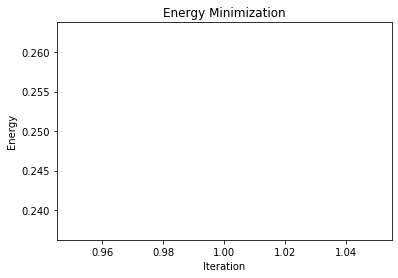

In [97]:
plt.title("Energy Minimization")
plt.plot(iteration,E)
plt.ylabel('Energy')
plt.xlabel('Iteration')
plt.show()

In [14]:
#Ground State
RBM_ansatz(a, b, W, Sbasis, N, M,sz)


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 6.90481918]
 [ 0.85841225]
 [30.92572615]
 [ 3.94881162]]

In [15]:
eps = 0.2
optimize.approx_fprime(W,varEnergy,eps,a,W,Sbasis, N, M,sz, H)

TypeError: only length-1 arrays can be converted to Python scalars